In [1]:
import numpy as np
import pandas as pd
from ase import Atoms
from ase import neighborlist
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.io.extxyz import read_extxyz, write_extxyz
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
def create_VAR_OLS_model(main, secondary, order=2):
    input = len(main)-order
    num_secondaries = secondary.shape[0]
    X = np.zeros([input,order*(num_secondaries+1)+1])
    for i in range(order):
        X[:,i*(num_secondaries+1)] = main[i:input+i]
        for j in range(num_secondaries):
            X[:,i*(num_secondaries+1)+j+1] = secondary[j,i:input+i]
    X[:,-1] = np.ones(len(main)-order)
    return sm.OLS(main[order:], X)
pred_step = 4
input = 6
#Load molecule data
mol = read(r"D:\KU\Masters\Gemma_group\Master thesis\Code\Data\EtOH_moldyn_NVE_please.traj", index)

print(len(mol))
# for different atoms
    #Create model
    #Predict the next steps
#Create array with all forces
forces = np.zeros((mol[0].get_forces().shape[0], mol[0].get_forces().shape[1], len(mol)))
for i in range(len(mol)):
    forces[:,:,i] = mol[i].get_forces()
   

pred_forces = np.zeros((forces.shape[0], forces.shape[1], pred_step))

n=0





    



ValueError: buffer is smaller than requested size

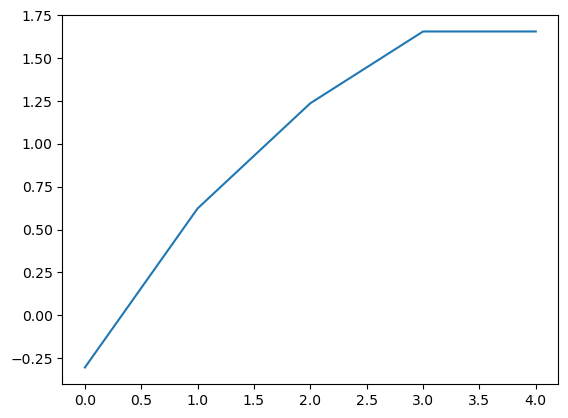

In [28]:
plt.plot(range(len(mol)), forces[0,0,:])